# Simple pendulum system

Consider a simple pendulum of length $l$ and mass $m$ concentrated at its bob. The pivot of the pendulum is attached to a fix point. The system is submitted to a uniform, constant gravitational acceleration field $g$ and moves without friction.

The generalised coordinate of the system is the angle $\theta$ of the pendulum with the downward vertical direction. The standard (Cartesian) coordinates of the bob are then given by

\begin{equation*}
x = l\sin\theta
\hspace{2cm}
y = -l\cos\theta
\end{equation*}

The only active force is weight with coordinates $(0,-mg)$, hence of the form $-\nabla V$ with $V=mgy=-mgl\cos\theta$. Hence the Lagrangian

\begin{equation*}
\mathcal{L} = ml(\frac{1}{2}l\dot{\theta}^2+g\cos\theta)
\end{equation*}

The equations of the dynamics are given by:

\begin{align*}
\left[\frac{\mathbf{d}}{\mathbf{d}t}\frac{\partial\mathcal{L}}{\partial\dot{\theta}} = \frac{\partial\mathcal{L}}{\partial\theta}\right]
\hspace{1.5cm} &
l\ddot{\theta} = -g\sin\theta
\end{align*}

Multiplying that equation by $\dot{\theta}$ and integrating yields $\dot{E}=0$ where $E$ is the total energy (constant) defined by

\begin{equation*}
E\triangleq\frac{1}{2}l^2\dot{\theta}^2-gl\cos\theta
\hspace{2cm}
\dot{E}=0
\end{equation*}

The time domain $\mathcal{D}^{(t)}$ is necessarily $\mathbb{R}$.

In [1]:
%pylab notebook
# for external animation (less resource consuming), use appropriate backend, e.g. qt5

import logging
from functools import partial
from ipyshow import Setup
from ipyshow.odesimu import System
from ipyshow.odesimu.util import logger_hook

Populating the interactive namespace from numpy and matplotlib


## Pendulum class

In [6]:
#----------------------------------------------------------------------------------------------------
class Pendulum (System):
#----------------------------------------------------------------------------------------------------

  shadowshape = (2,)

  @Setup(
    'L: length of the pendulum [m]',
    'G: intensity of the gravitation [m.sec^-2]',
  )
  def __init__(self,L,G):
    self.L, self.G = L, G
    self.a = a = -G/L
    def main(t,state):
      θ,θʹ = state
      θʺ = a*sin(θ)
      return array((θʹ,θʺ))
    self.main = main
    def jac(t,state):
      θ,θʹ = state
      return array(((0,1),(a*cos(θ),0)))
    self.jacobian = jac
    def fordisplay(state):
      θ,θʹ = state
      live = L*array((sin(θ),-cos(θ)))
      return live, live
    self.fordisplay = fordisplay

  def display(self,ax,ini=None,refsize=None,**ka):
    L = 1.05*self.L
    ax.set(xlim=(-L,L),ylim=(-L,L))
    ax.scatter((0.,),(0.,),c='k',marker='o',s=refsize)
    diag_l, = ax.plot((),(),'k')
    diag_s = ax.scatter((),(),s=refsize,marker='o',c='r')
    tail_l, = ax.plot((),(),'y')
    self.trajectory(ax,ini)
    def disp(t,live,tail):
      x,y = live
      diag_l.set_data((0,x),(0,y))
      diag_s.set_offsets(((x,y),))
      tail_l.set_data(tail[:,0],tail[:,1])
    return super().display(ax,disp,ini=ini,**ka)

  def analytics(self,ini):
    θ,θʹ = ini
    return .5*square(θʹ*self.L)-self.L*self.G*cos(θ)

  def trajectory(self,ax,ini):
    from scipy.integrate import quad
    from matplotlib.patches import Arc
    E = self.analytics(ini)
    c = -E/(self.L*self.G)
    if c==-1: periodicity = ''
    else:
      if c<-1: periodicity = 'incremental period'; α = pi
      else: periodicity = 'half-period'; α = arccos(c)
      T = pi/sqrt(2) if α<.1 else quad((lambda θ,c=c: 1/sqrt(cos(θ)-c)),0,α)[0]
      T *= sqrt(-2/self.a)
      periodicity += f':{T:.2f}'
    ax.add_patch(Arc((0,0),2*self.L,2*self.L,-90,-degrees(α),degrees(α),color='k',ls='dashed'))
    ax.set_title(f'trajectory:CircularSegment($R$={self.L:.2f},$\\alpha$={degrees(α):.2f}) {periodicity}')

  @staticmethod
  @Setup(
    'θ: angle [deg]',
    'θʹ: angular speed [deg.sec^-1]',
    θʹ=0.
  )
  def makestate(θ,θʹ): return radians((θ,θʹ))

  @Setup(
    System.launch,
    'refsize: average size (area) of the bob for display [pt^2]',
    taild=1.,refsize=50.,hooks=(partial(logger_hook,logger=logging.getLogger()),)
  )
  def launch(self,*a,**ka): return super().launch(*a,**ka)

In [7]:
Setup.display(Pendulum)

**** Pendulum.__init__(self, L, G) ****
    L         : length of the pendulum [m]
    G         : intensity of the gravitation [m.sec^-2]
**** Pendulum.launch(self, *a, **ka) ****
    ini       : initial state []
    srate     (25.0      ): sampling rate [sec^-1]
    maxtime   (inf       ): total simulation time length [sec]
    taild     (1.0       ): shadow duration [sec]
    listeners : listener binding (events: start,stop,step,error) []
    hooks     ((functools): list of display hooks []
    refsize   (50.0      ): average size (area) of the bob for display [pt^2]
**** Pendulum.makestate(θ, θʹ) ****
    θ         : angle [deg]
    θʹ        (0.0       ): angular speed [deg.sec^-1]

<IPython.core.display.Javascript object>


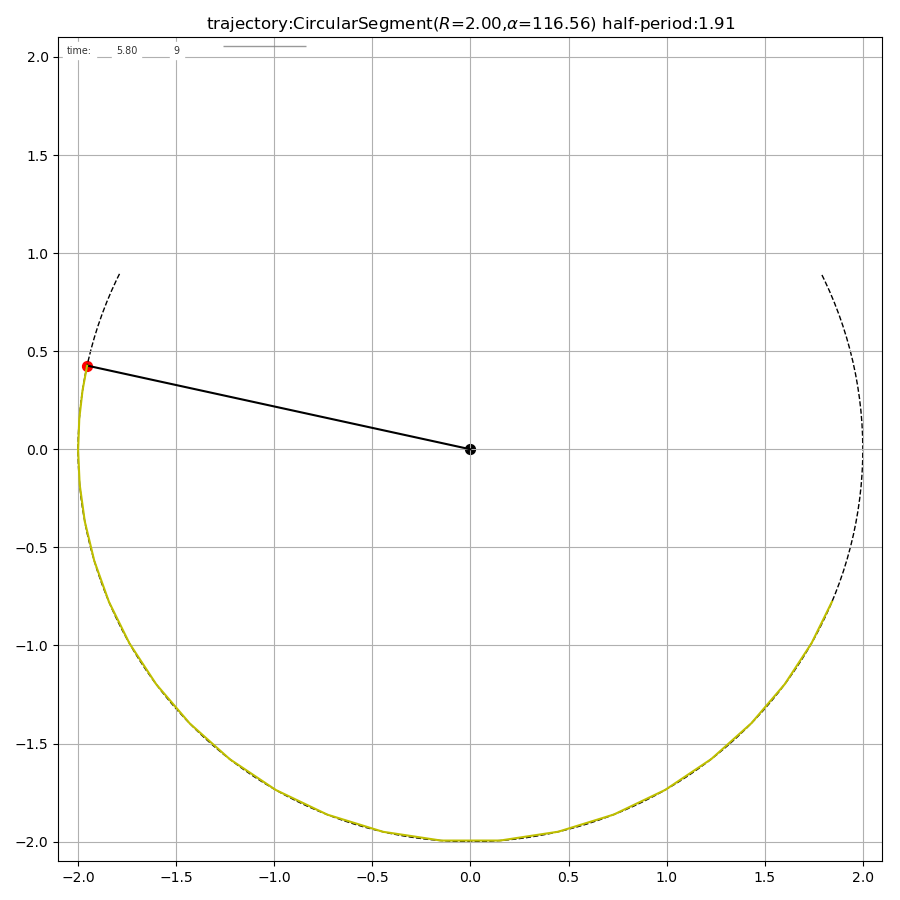

In [8]:
logging.basicConfig(level='WARN') # can be changed dynamically by logger_hook
syst = Pendulum(L=2.,G=9.81,)
ini = dict(θ=90.,θʹ=120.)
#ini = dict(θ=90.,θʹ=179)
#ini = dict(θ=90.,θʹ=181)
#ini = dict(θ=179.)
syst.launch(ini=syst.makestate(**ini))

## Trajectory

The trajectory is a circle arc (or full circle).The equation of the total energy is given by $\dot{\theta}^2=\frac{2g}{l}(\cos\theta-c)$ where $c=-\frac{E}{lg}$. Note that by construction $c\leq1$.

### Time as a function of angle

Consider a time interval $\mathcal{T}$ and $\epsilon\in\{-1,+1\}$ such that

* $\theta$ is increasing (if $\epsilon=+1$) or decreasing (if $\epsilon=-1$) on $\mathcal{T}$

The main equation on $\mathcal{T}$ becomes

\begin{equation*}
\dot{\theta} = \epsilon\sqrt{\frac{2g}{l}}\sqrt{\cos\theta-c}
\end{equation*}

* If $c\lt-1$ then the trajectory is the whole circle ($\alpha=\pi$) and the motion is incremental periodic;

* if $c=-1$ the trajectory is a circle segment ending at the top-most point of the circle, toward which the bob converges (but which it never reaches);

* if $-1\lt c\lt1$ the trajectory is a circle segment limited by the angles $-\alpha$ and $\alpha$ where $\alpha=\arccos c$ and the motion is periodic;

* if $c=1$, the trajectory is the bottom-most point of the circle and the motion is null;

### Periodicity when $-1<c<1$

When $|c|<1$, the motion is periodic and, since $c=\cos\alpha$, using the change of variable $\theta=t\alpha$, the **half-period** is given by

\begin{equation*}
T=\sqrt{\frac{2l}{g}}I(\alpha)
\hspace{1cm}\textrm{where}\hspace{1cm}
I(\alpha)\triangleq\int_0^\alpha\frac{\mathbf{d}\theta}{\sqrt{\cos\theta-\cos\alpha}}=
\int_0^1\frac{\alpha\mathbf{d}t}{\sqrt{\cos t\alpha-\cos\alpha}} =
\int_0^1\frac{\alpha\mathbf{d}t}{\sqrt{2\sin\frac{1+t}{2}\alpha\sin\frac{1-t}{2}\alpha}}
\end{equation*}

When $t\rightarrow1$, we have $2\sin\frac{1+t}{2}\alpha\sin\frac{1-t}{2}\alpha\sim(1-t)\alpha\sin\alpha$ and since $\int_0^1\frac{\mathbf{d}t}{\sqrt{1-t}}$ is finite, so is $I(\alpha)$. Furthermore, the integrand is monotone increasing in $\alpha$, hence so is $I(\alpha)$.

* When $\alpha$ tends to $0$, the integrand converges pointwise to $\sqrt{\frac{2}{1-t^2}}$ and is dominated by $\frac{\pi}{2}\sqrt{\frac{2}{1-t^2}}$. By the [dominated convergence theorem](https://en.wikipedia.org/wiki/Dominated_convergence_theorem), using the change of variable $t=\sin u$, we have
\begin{equation*}
\lim_{\alpha\rightarrow0}I(\alpha) = \int_0^1\frac{\sqrt{2}\mathbf{d}t}{\sqrt{1-t^2}} =
\int_0^{\frac{\pi}{2}}\frac{\sqrt{2}\cos u\mathbf{d}u}{\sqrt{1-\sin^2u}} = \frac{\pi}{\sqrt{2}}
\hspace{1cm}\textrm{hence}\hspace{1cm}
\lim_{c\rightarrow1^-}T = \pi\sqrt{\frac{l}{g}}
\end{equation*}

* When $\alpha$ tends to $\pi$, the integrand converges pointwise to $\frac{\pi}{\sqrt{2}\cos(\frac{\pi}{2}t)}$. By the [monotone convergence theorem](http://en.wikipedia.org/wiki/Monotone_convergence_theorem), using the change of variable $t=1-\frac{2u}{\pi}$, we have
\begin{equation*}
\lim_{\alpha\rightarrow\pi}I(\alpha) = \int_0^1\frac{\pi\mathbf{d}t}{\sqrt{2}\cos(\frac{\pi}{2}t)} =
\sqrt{2}\int_0^{\frac{\pi}{2}}\frac{\mathbf{d}u}{\sin u} = \infty
\hspace{1cm}\textrm{hence}\hspace{1cm}
\lim_{c\rightarrow-1^+}T = \infty
\end{equation*}

### Incremental periodicity when $c<-1$

When $c<-1$, the motion is incremental periodic and the **incremental period** is given by

\begin{equation*}
T = \sqrt{\frac{2l}{g}}\int_0^\pi\frac{\mathbf{d}\theta}{\sqrt{\cos\theta-c}}
\end{equation*}

When $c$ tends to $-1$, the integrand converges pointwise to $\frac{1}{\sqrt{1+\cos\theta}}$. By the monotone convergence theorem, and using the change of variable $u=\frac{\pi-\theta}{2}$, we have
\begin{equation*}
\lim_{c\rightarrow-1^-}T = \int_0^\pi\frac{\mathbf{d}\theta}{1+\cos\theta} =
\int_0^{\frac{\pi}{2}}\frac{\mathbf{d}u}{\sin^2u} = \infty
\end{equation*}